# Modelo AR(p) Disney
Katlyn Goeujon-Mackness <br>
29/04/2025

## Introducción
### Objetivo
Breve descripción del objetivo del análisis.

### Modelos AR(p)
**El modelo AR(1), o modelo autoregresivo de orden 1**, se utiliza en series de tiempo para predecir el valor actual de una variable basándose en su valor inmediatamente anterior. Es el modelo autoregresivo más básico y se utiliza como base para modelos más complejos, como AR(p) de órdenes superiores.

#### Componentes
* media constante mu (𝜇)
* coeficiente phi (𝜙)
* término de error de ruido blanco

El modelo es especialmente útil para series temporales estacionarias donde 𝜙 está entre -1 y 1, con dos casos importantes:
1. 𝜙 positivo: Con "Momentum", genera una correlación positiva y un crecimiento que decae con el tiempo.
2. 𝜙 negativo: Con inversión de media, produce alternancias entre subidas y bajadas en las observaciones.

### Contexto del Conjunto de Datos
Consideraremos la información histórica diaria de precios para la empresa Walt Disney Company (cuya sigla bursátil es “DIS”) contenida en el sitio de Yahoo Finance para el periodo que va del 1 de Enero del 2023 al 31 de Marzo del 2023 usando los modelos auto-regresivos AR(p).

## Implementación
Utilizaremos librerías estadísticas para implementar modelos AR(1) en el análisis de precios de acciones. Veremos cómo ajustar modelos a datos de entrenamiento y realizar predicciones precisas.

In [ ]:
# Importar librerías
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error

In [5]:
# Cargar los datos históricos desde Yahoo Finance
disney = yf.download(tickers='dis', start='2023-01-01', end='2023-03-31', rounding=True)
disney

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,DIS,DIS,DIS,DIS,DIS
Date,,,,,
2023-01-03,87.88,88.87,86.76,87.89,14997100
2023-01-04,90.86,91.62,88.27,88.90,14957200
2023-01-05,90.80,91.35,89.41,90.54,11622600
2023-01-06,92.77,93.53,90.21,91.53,9828100
2023-01-09,93.61,94.53,92.31,93.28,11675800
...,...,...,...,...,...
2023-03-24,92.93,93.84,91.88,93.65,9534600
2023-03-27,94.45,94.85,93.23,93.62,7487900


In [6]:
disney = disney['Close']
disney

Ticker,DIS
Date,
2023-01-03,87.88
2023-01-04,90.86
2023-01-05,90.80
2023-01-06,92.77
2023-01-09,93.61
...,...
2023-03-24,92.93
2023-03-27,94.45
2023-03-28,93.66


## Exploración de Datos

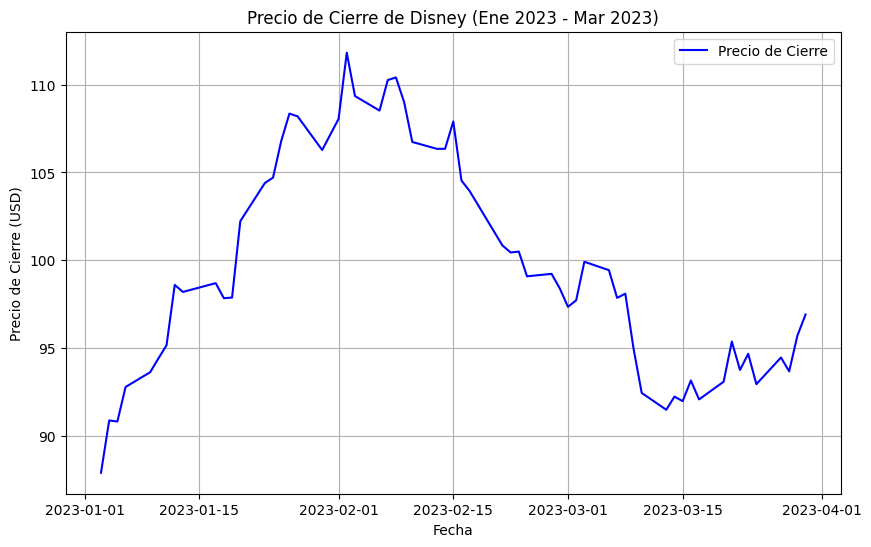

In [7]:
# Graficar los datos de cierre de Disney
plt.figure(figsize=(10, 6))
plt.plot(disney, label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre de Disney (Ene 2023 - Mar 2023)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.grid()
plt.show()

## Modelación

### División de Datos

In [8]:
# Dividir los datos en conjuntos de entrenamiento (70%) y prueba (30%).
disney.index = pd.to_datetime(disney.index)
len_train = int(len(disney)*0.8)
len_train
# Ajustar el índice para usar fechas.

48

In [9]:
len_test = int(len(disney)*0.2)
len_test

12

In [10]:
# Definición de grupos de prueba y entrenamiento
train = disney[0:len_train]


In [12]:
test = disney[len_train:]

### Análisis de Autocorrelación

In [ ]:
# Generar gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF).

# Identificar el orden 𝑝 del modelo AR(p) más adecuado.

In [ ]:
# Calcular los valores de AIC y BIC para diferentes órdenes 𝑝.

# Seleccionar el modelo con los valores más bajos.

### Ajuste del Modelo

In [ ]:
# Entrenar el modelo AR(p) seleccionado en el conjunto de entrenamiento.

# Evaluar el ajuste del modelo.

### Pronóstico

In [ ]:
# Generar predicciones puntuales para el mes de abril de 2023.

# Calcular intervalos de confianza del 90% para las predicciones.

### Evaluación del Modelo

In [4]:
# Calcular métricas de error como RMSE y MAPE.

# Analizar la precisión de las predicciones.

## Visualización de Resultados

In [ ]:
# Graficar los datos históricos, predicciones y sus intervalos de confianza.

# Usar colores para distinguir los diferentes conjuntos de datos.

## Conclusiones

In [ ]:
# Resumir los hallazgos del análisis.

# Reflexionar sobre la precisión del modelo y posibles mejoras.